<a id="top"></a>
## Reading Edgar with Python
2020-09-21

[EDGAR](https://www.sec.gov/edgar.shtml) is the repository for filings from publicly reporting companies. There are search pages that provide a facility for browser users to find filings, but the responses are high-tech stuff I don't know how to read except with a browser. Fortunately, filings are listed in archives with names like "/".join(('www.sec.gov', 'Archives', 'edgar', 'full-index', '<i>%Y</i>', 'QTR<i>%d</i>' %(quarter), 'form.gz')). Starting with 1994. It's simple to grab those archives and then search those user friendly gzipped text files. 

We start by saving a local copy of all the form.gz in a directory formIndex/.

One minor monkey wrench is that when the index gives a not quite correct name, but the hint is close enough that we can fix it. 
- index says: edgar/data/1821685/0001104659-20-101638.txt
- should be : edgar/data/0001821685/000110465920101638/0001104659-20-101638.txt

We read one file from the index to prove we have it right. 

In [1]:
import pandas as pd
import requests
from gzip import GzipFile as gz 
import os
import shutil
from datetime import datetime as dt
from matplotlib import pyplot as plt

In [2]:
IDXPATH = "formIndex" # local directory name
fntS = "forms{year}Q{q}.txt.gz"  # name for local copies

for year in range(1994, 1 + dt.now().year):
    for Q in range(1, 5):
        shortS = "/".join(('www.sec.gov', 'Archives', 'edgar', 'full-index', "%d" %(year) \
                           , 'QTR%d' %(Q), 'form.gz'))
        pathS = "".join(("https://", shortS))
        try:
            req = requests.get(pathS, allow_redirects=True, stream=True)
            hs = int(req.headers.get('content-length'))
        except:
            hs = -1
            
        if hs < 260:
            print ("skipping",  pathS, "with length", hs) # because nothing good can be that small
        else:
            otF = open(os.path.join(IDXPATH, fntS.format(year=year, q=Q)), "wb")
            shutil.copyfileobj(req.raw, otF)
            req.close()
            otF.close()

skipping https://www.sec.gov/Archives/edgar/full-index/2020/QTR4/form.gz with length 243


### Looking at the top of one of the files

In [3]:
inF = gz(os.path.join(IDXPATH, fntS.format(year=1994, q=1)))
maxLines = 15
lines = 0
for line in inF:
    lines += 1
    if lines > maxLines:
        break
    print (line[:-1])

b'Description:           Master Index of EDGAR Dissemination Feed by Form Type'
b'Last Data Received:    March 31, 1994'
b'Comments:              webmaster@sec.gov'
b'Anonymous FTP:         ftp://ftp.sec.gov/edgar/'
b' '
b' '
b' '
b' '
b'Form Type   Company Name                                                  CIK         Date Filed  File Name'
b'---------------------------------------------------------------------------------------------------------------------------------------------'
b'10-12B      MICRO SECURITY SYSTEMS INC                                    736469      1994-02-11  edgar/data/736469/0000736469-94-000001.txt          '
b'10-12B/A    SCOTSMAN INDUSTRIES INC                                       846660      1994-01-27  edgar/data/846660/0000950124-94-000188.txt          '
b'10-C        ADELPHIA COMMUNICATIONS CORP                                  796486      1994-01-18  edgar/data/796486/0000950132-94-000013.txt          '
b'10-C        BANC ONE CORP/OH/               

#### Data Format 
The text is Fixed Format rather than delimited. In case the start position ever changes, we look for the start positions each time. Below a function to convert a file to a DF. It turns out the starting locations never change, but just in case. 

In [4]:
def formDf2DF(infn, verbose=False):
    """
    read gzipped format index and return DF
    ignore data before "Form Type"
    use first row to find statrpos for 
        FormType
        CompanyName
        CIK
        DateFiled
        FileName
    """
    try:
        inF = gz(infn)
    except:
        print ("could not open gzipped file %s" %(infn))
        return 1
    
    tD = {x: [] for x in "FormType CompanyName CIK DateFiled FileName".split()} # data
    rD = {x: () for x in "FormType CompanyName CIK DateFiled FileName".split()} # location

    using = False
    for line in inF:
        try:
            ld = line.decode()[:-1]
        except:
            ld = line.decode("ISO-8859-2")[:-1]
        
        if ld[:4] == "Form":
            # look for startpos
            rD["FormType"] = (0, ld.index("Company"))
            rD["CompanyName"] = (ld.index("Company"), ld.index("CIK"))
            rD["CIK"] = (ld.index("CIK"), ld.index("Date"))
            rD["DateFiled"] = (ld.index("Date"), ld.index("Date") + 10)
            rD["FileName"] = (ld.index("Date") + 10, 1234)
            using = True
            continue
        elif using:
            if ld[0] == "-":
                continue 
            for fn in "FormType CompanyName CIK DateFiled FileName".split():
                tD[fn].append(ld[rD[fn][0]: rD[fn][1]].strip())
        else:
            pass
        
    if verbose:
        print (rD)
    
    return pd.DataFrame(tD)

#### testing fn
First record of one file looks good. That means the function must be good. 

In [5]:
tR = formDf2DF(os.path.join(IDXPATH, "forms2011Q4.txt.gz"))
tR.iloc[0]

FormType                                                 1
CompanyName                       BOX Options Exchange LLC
CIK                                                1540528
DateFiled                                       2011-12-19
FileName       edgar/data/1540528/9999999997-12-000395.txt
Name: 0, dtype: object

#### consolidating
Here pullig all files into one dataframe. 

In [6]:
goodFileL = [os.path.join(IDXPATH, x) for x in os.listdir(IDXPATH)]
tL = list(map(formDf2DF, goodFileL))
consolR = pd.concat(tL)
consolR["yearFiled"] = consolR.DateFiled.str.slice(stop=4).astype(int)
consolR.yearFiled.value_counts().sort_index()

1994      65461
1995     113651
1996     202614
1997     280130
1998     313300
1999     321262
2000     341962
2001     351443
2002     448884
2003     790772
2004    1024212
2005    1072293
2006    1096629
2007    1137504
2008    1036835
2009     938510
2010     979764
2011     979653
2012     975111
2013     990606
2014     996892
2015     995491
2016     953061
2017     971350
2018     949919
2019     951352
2020     788478
Name: yearFiled, dtype: int64

#### Most popular forms for 2020

In [7]:
consolR.query("yearFiled == 2020").FormType.value_counts().head()

4           292916
8-K          54478
424B2        47872
NPORT-P      32480
SC 13G/A     29790
Name: FormType, dtype: int64

#### Looking for one type of form 

In [8]:
def isABSee(s):
    if s[:6] == "ABS-EE":
        return 1
    else:
        return 0

consolR["isABSee"] = list(map(isABSee, consolR.FormType))
consolR.query("isABSee == 1").FormType.value_counts()

ABS-EE      11958
ABS-EE/A      210
Name: FormType, dtype: int64

#### And because we always need a chart
Counting the number of ABS-EE and AMSEE/A per month since the beginning of ABS-EE. The increase is steady because we accumulate more reporters. 

In [9]:
# filtering to speed
absR = consolR.query("isABSee == 1").copy()

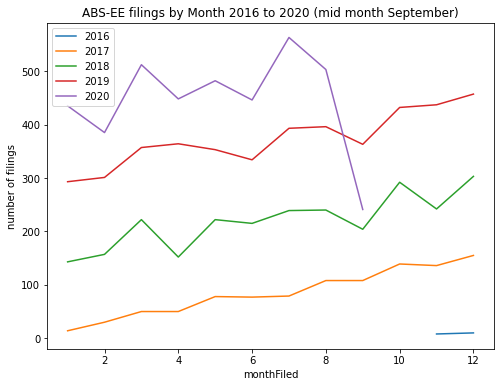

In [10]:
absR["monthFiled"] = absR.DateFiled.str[5:7].astype(int)
countR = absR.groupby("yearFiled monthFiled".split()).isABSee.sum().reset_index()
fig, ax = plt.subplots(figsize=(8, 6))
for year in range(2016, 2021):
    tR = countR.query("yearFiled == @year")
    tR.plot("monthFiled", "isABSee", label=year, ax=ax)

ax.set_title("ABS-EE filings by Month 2016 to 2020 (mid month September)")
ax.set_ylabel("number of filings")
plt.legend()

#### Saving for later

In [11]:
absR.iloc[0]

FormType                                            ABS-EE
CompanyName                               AFS SENSUB CORP.
CIK                                                1347185
DateFiled                                       2019-04-02
FileName       edgar/data/1347185/0001347185-19-000018.txt
yearFiled                                             2019
isABSee                                                  1
monthFiled                                               4
Name: 196182, dtype: object

In [13]:
absR.sort_values("CompanyName DateFiled FormType".split()).to_excel("index.xlsx", index=False)

### Editing name

In [12]:
EDGAR = "https://www.sec.gov/Archives"
def fixName(s):
    """
    Parameters
    ----------
    s : str
        The name from edgar index

    Returns
    -------
    str : The actual name
    
    When EDGAR says the name is 
        edgar/data/1821685/0001104659-20-101638.txt
    What they mean is that the name is https://www.sec.gov/Archives/ + 
        edgar/data/0001821685/000110465920101638/0001104659-20-101638.txt
    """
    sL = s.split("/")
    nL = [EDGAR] + sL[:2]
    nL.append("%010d" %(int(sL[2])))
    
    nL.append(sL[-1].split(".")[0].replace("-", ""))
    nL.append(sL[-1])
    
    return "/".join(nL)

print (absR.iloc[0].FileName)
print (fixName(absR.iloc[0].FileName))

edgar/data/1347185/0001347185-19-000018.txt
https://www.sec.gov/Archives/edgar/data/0001347185/000134718519000018/0001347185-19-000018.txt


#### Reading to show that we really got a doc

In [13]:
tempText = requests.get(fixName(absR.iloc[0].FileName)).text
len(tempText)

190047962

In [14]:
for line in tempText.split("\n")[:10]:
    print (line[:80])

<SEC-DOCUMENT>0001347185-19-000018.txt : 20190402
<SEC-HEADER>0001347185-19-000018.hdr.sgml : 20190402
<ACCEPTANCE-DATETIME>20190402125549
ACCESSION NUMBER:		0001347185-19-000018
CONFORMED SUBMISSION TYPE:	ABS-EE
PUBLIC DOCUMENT COUNT:		3
CONFORMED PERIOD OF REPORT:	20190228
<DEPOSITOR-CIK>0001347185
<SPONSOR-CIK>0001002761
FILED AS OF DATE:		20190402
